In [2]:
# 클러스터링 목표
"""데이터의 내재된 구조를 발견 -> 클러스터링 -> 각 클러스터 별 구매율 계산 → 구매율이 높은 군집을 식별 & 해당 군집의 특성 분석 → 소셜 네트워크 마케팅 전략 수립"""
# 클러스터링 과정
"""
1. 탐색적 데이터 분석(EDA)
2. 데이터 전처리
3. 클러스터링 : K-Means(k=3,7), Hierarchical Clustering(k=3,7)
4. 클러스터링 결과 해석
5. 클러스터링 성능 비교
"""

'\n1. 탐색적 데이터 분석(EDA)\n2. 데이터 전처리\n3. 클러스터링 : K-Means(k=3,7), Hierarchical Clustering(k=3,7)\n4. 클러스터링 결과 해석\n5. 클러스터링 성능 비교\n'

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import scipy.stats as stats
from scipy.stats import norm
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import (
    dendrogram,
    linkage,
    fcluster,
    set_link_color_palette,
)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

In [4]:
# CSV 파일 불러오기
df = pd.read_csv("Data/Social_Network_Ads.csv")

In [5]:
# [1. 탐색적 데이터 분석(EDA)]
# 데이터 구조 확인
df.info(), df.head(), df.shape

# 결측치 : 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


(None,
     User ID  Gender  Age  EstimatedSalary  Purchased
 0  15624510    Male   19            19000          0
 1  15810944    Male   35            20000          0
 2  15668575  Female   26            43000          0
 3  15603246  Female   27            57000          0
 4  15804002    Male   19            76000          0,
 (400, 5))

In [6]:
# 데이터 기초통계량 확인
df.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [7]:
# 컬럼 별 고유값 확인
unique_value_counts = {col: df[col].value_counts() for col in df.columns}

for col, value_counts in unique_value_counts.items():
    print(f"Column: {col}")
    print("Unique Values and Counts:")
    for value, count in value_counts.items():
        print(f" - {value} ({count})")
    print("\n")

Column: User ID
Unique Values and Counts:
 - 15624510 (1)
 - 15767681 (1)
 - 15589449 (1)
 - 15791373 (1)
 - 15688172 (1)
 - 15680752 (1)
 - 15583137 (1)
 - 15746203 (1)
 - 15581282 (1)
 - 15721592 (1)
 - 15801336 (1)
 - 15600379 (1)
 - 15672821 (1)
 - 15810944 (1)
 - 15680587 (1)
 - 15811177 (1)
 - 15815236 (1)
 - 15569641 (1)
 - 15794493 (1)
 - 15609637 (1)
 - 15750056 (1)
 - 15724161 (1)
 - 15584320 (1)
 - 15795298 (1)
 - 15692819 (1)
 - 15727467 (1)
 - 15734312 (1)
 - 15764604 (1)
 - 15675791 (1)
 - 15705298 (1)
 - 15673539 (1)
 - 15725794 (1)
 - 15566689 (1)
 - 15760570 (1)
 - 15625395 (1)
 - 15596522 (1)
 - 15586757 (1)
 - 15713912 (1)
 - 15649668 (1)
 - 15761950 (1)
 - 15631070 (1)
 - 15734161 (1)
 - 15638646 (1)
 - 15663249 (1)
 - 15750447 (1)
 - 15685536 (1)
 - 15609669 (1)
 - 15759684 (1)
 - 15613014 (1)
 - 15723373 (1)
 - 15810075 (1)
 - 15753102 (1)
 - 15575002 (1)
 - 15694879 (1)
 - 15663161 (1)
 - 15789432 (1)
 - 15732987 (1)
 - 15666675 (1)
 - 15582066 (1)
 - 15636023 (1

In [8]:
# 이상치 확인
# IQR -> 박스플롯 시각화
"""
[필기 내용]
- IQR은 이상치 확인에 한계가있음
- major/minor 집단 확인 95% CI영역 -> 바깥이 outlier 가능성 있음(1차적 outlier 분류기준)
- 아웃라이어가 애초에 없을수도; 피처특성 파악이 우선
- age -> sns 구매전환여부. 온라인거래 어려운 연령대는 아웃라이어로 파악(너무어리거나 너무늙거나)
- 구매 가능성이 있는 만13세~65세 만 인정
- 진짜로 잘버는 미성년자일수도있지만, 통계대상에 포함될 필요X
- 성능평가 : 실루엣 점수가 높더라도, 분류한 클러스터 내 n수가 불균형하면 좋은 클러스터링 모델이 아님
"""

'\n[필기 내용]\n- IQR은 이상치 확인에 한계가있음\n- major/minor 집단 확인 95% CI영역 -> 바깥이 outlier 가능성 있음(1차적 outlier 분류기준)\n- 아웃라이어가 애초에 없을수도; 피처특성 파악이 우선\n- age -> sns 구매전환여부. 온라인거래 어려운 연령대는 아웃라이어로 파악(너무어리거나 너무늙거나)\n- 구매 가능성이 있는 만13세~65세 만 인정\n- 진짜로 잘버는 미성년자일수도있지만, 통계대상에 포함될 필요X\n- 성능평가 : 실루엣 점수가 높더라도, 분류한 클러스터 내 n수가 불균형하면 좋은 클러스터링 모델이 아님\n'

In [9]:
# 'Age' : CI(Confidence Interval; 신뢰구간)로 이상치 탐지


# 신뢰구간 95%를 기준으로 Age의 이상치를 탐지하는 함수
def detect_outliers_ci(df, confidence=0.95):
    outliers = {}
    for column in df.select_dtypes(include=[np.number]).columns:  # 수치형 변수만 고려
        mean = df[column].mean()
        std = df[column].std()
        ci = stats.norm.interval(confidence, loc=mean, scale=std)
        lower_bound, upper_bound = ci
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers


# Age에서 95% 신뢰구간을 사용하여 이상치 탐지
outliers_ci = detect_outliers_ci(df[["Age"]])

# Age 열의 이상치 출력
outliers_ci["Age"]

,Age
64,59
212,59
215,60
219,59
223,60
271,59
272,60
280,59
355,60
365,59


In [10]:
# 'EstimatedSalary' : 미국 나이별 중위소득 데이터를 사용하여 이상치 탐지

# 나이별 중위소득 설정 (연소득 기준, 2023년)
actual_median_income_by_age = {
    (16, 19): 31928,
    (20, 24): 38194,
    (25, 34): 54340,
    (35, 44): 65234,
    (45, 54): 65247,
    (55, 64): 63310,
    (65, 100): 56238,
}


# 주어진 나이에 해당하는 소득 범위를 계산하는 함수 정의
def get_actual_income_range(age):
    for age_range, median_income in actual_median_income_by_age.items():
        if age_range[0] <= age <= age_range[1]:
            lower_bound = median_income * 0.5
            upper_bound = median_income * 1.75  # +75% 범위로 설정
            return lower_bound, upper_bound
    return None, None


# 위로 75% 이상 범위를 벗어나는 이상치 식별 및 제거
outliers_upper_75 = []
for index, row in df.iterrows():
    lower_bound, upper_bound = get_actual_income_range(row["Age"])
    if upper_bound is not None and row["EstimatedSalary"] > upper_bound:
        outliers_upper_75.append((index, row["Age"], row["EstimatedSalary"]))

# 이상치를 데이터프레임에서 제거
df.drop([outlier[0] for outlier in outliers_upper_75], inplace=True)

# 제거된 이상치 출력
outliers_upper_75

[(4, 19, 76000),
 (7, 32, 150000),
 (12, 20, 86000),
 (14, 18, 82000),
 (31, 27, 137000),
 (48, 30, 135000),
 (59, 32, 117000),
 (63, 32, 120000),
 (67, 23, 82000),
 (73, 33, 113000),
 (75, 34, 112000),
 (85, 31, 118000),
 (90, 22, 81000),
 (91, 30, 116000),
 (97, 28, 123000),
 (103, 33, 149000),
 (105, 21, 72000),
 (133, 21, 68000),
 (136, 20, 82000),
 (137, 30, 107000),
 (140, 19, 85000),
 (141, 18, 68000),
 (145, 24, 89000),
 (146, 27, 96000),
 (149, 20, 74000),
 (159, 32, 135000),
 (160, 32, 100000),
 (165, 18, 86000),
 (168, 29, 148000),
 (170, 21, 88000),
 (171, 34, 115000),
 (172, 26, 118000),
 (182, 32, 117000),
 (186, 20, 82000),
 (190, 24, 84000),
 (193, 19, 70000),
 (202, 39, 134000),
 (206, 55, 130000),
 (208, 40, 142000),
 (211, 52, 150000),
 (219, 59, 143000),
 (222, 37, 144000),
 (226, 36, 126000),
 (227, 56, 133000),
 (230, 35, 147000),
 (239, 53, 143000),
 (240, 42, 149000),
 (245, 51, 146000),
 (247, 57, 122000),
 (252, 48, 134000),
 (253, 37, 146000),
 (259, 45, 1310

In [11]:
df.shape

(327, 5)

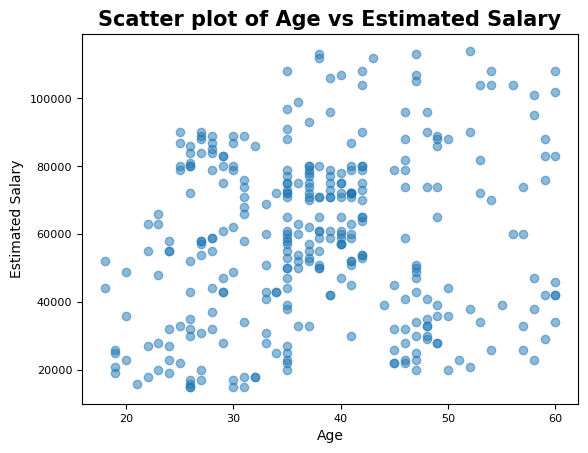

In [12]:
# 나이와 연수입 산점도 그리기
plt.scatter(df["Age"], df["EstimatedSalary"], alpha=0.5)
plt.title("Scatter plot of Age vs Estimated Salary", fontsize="15", fontweight="bold")
plt.xlabel("Age", fontsize="10")
plt.ylabel("Estimated Salary", fontsize="10")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

C:\Users\boar2\AppData\Local\Temp\ipykernel_17796\4020828056.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, "k", linewidth=2, color="blue")


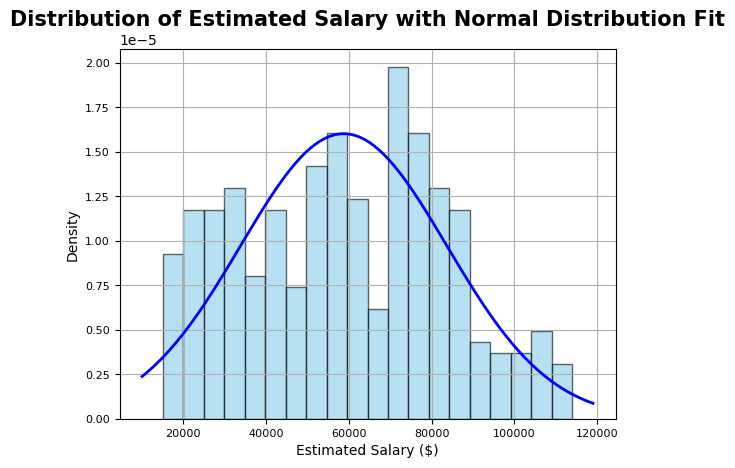

In [13]:
# 피처 별 분포 확인

# 'EstimatedSalary' : 히스토그램
plt.hist(
    df["EstimatedSalary"],
    bins=20,
    density=True,
    color="skyblue",
    edgecolor="black",
    alpha=0.6,
)
plt.title(
    "Distribution of Estimated Salary with Normal Distribution Fit",
    fontsize="15",
    fontweight="bold",
)
plt.xlabel("Estimated Salary ($)", fontsize="10")
plt.ylabel("Density", fontsize="10")
plt.grid(True)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 정규 분포 곡선 추가
mu, std = stats.norm.fit(df["EstimatedSalary"])  # 평균과 표준편차 계산
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2, color="blue")

plt.show()

C:\Users\boar2\AppData\Local\Temp\ipykernel_17796\3492712828.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, "k", linewidth=2, color="blue")


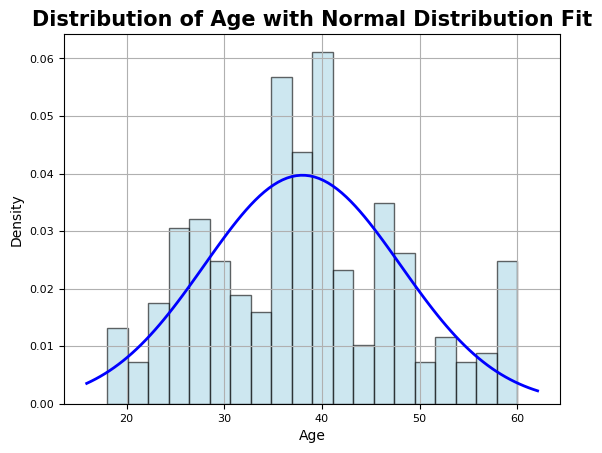

In [14]:
# (2) 'Age' : 히스토그램
plt.hist(
    df["Age"], bins=20, density=True, color="lightblue", edgecolor="black", alpha=0.6
)
plt.title(
    "Distribution of Age with Normal Distribution Fit", fontsize="15", fontweight="bold"
)
plt.xlabel("Age", fontsize="10")
plt.ylabel("Density", fontsize="10")
plt.grid(True)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 정규 분포 곡선 추가
mu, std = stats.norm.fit(df["Age"])  # 평균과 표준편차 계산
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2, color="blue")

plt.show()

In [15]:
# [2. 데이터 전처리]
# (1)'Gender' 피처에서 Male → 0, Female → 1 으로 인코딩
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1})

# 변환된 데이터 확인
df.head()

C:\Users\boar2\AppData\Local\Temp\ipykernel_17796\206843430.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1})


,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,0,19,19000,0
1,15810944,0,35,20000,0
2,15668575,1,26,43000,0
3,15603246,1,27,57000,0
5,15728773,0,27,58000,0


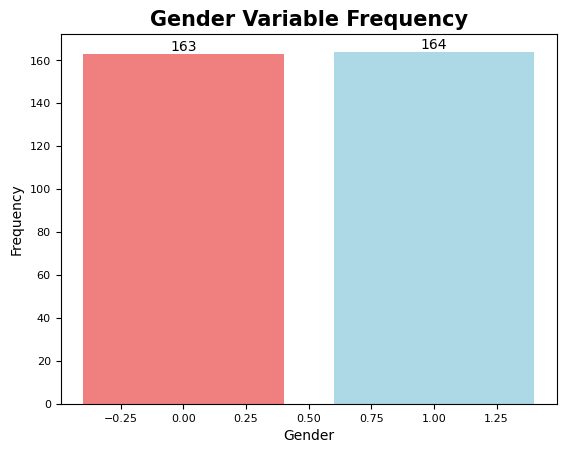

In [16]:
# 데이터 빈도 파악

# Gender 변수의 빈도 계산
gender_counts = df["Gender"].value_counts()

# Gender 변수의 값에 대한 막대그래프 시각화
bars = plt.bar(
    gender_counts.index, gender_counts.values, color=["lightblue", "lightcoral"]
)
plt.title("Gender Variable Frequency", fontsize="15", fontweight="bold")
plt.xlabel("Gender", fontsize="10")
plt.ylabel("Frequency", fontsize="10")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 각 막대 위에 빈도 수를 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, yval, int(yval), ha="center", va="bottom"
    )

plt.show()

C:\Users\boar2\AppData\Local\Temp\ipykernel_17796\2834596555.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, "k", linewidth=2, color="green")


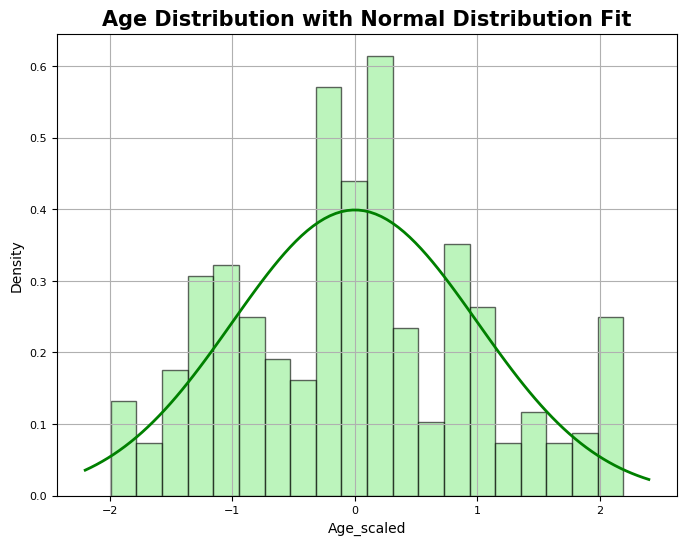

In [17]:
# (2)'Age' 스케일링(표준화; 평균0 표준편차1)

# Age 표준화
scaler = StandardScaler()
df["Age_scaled"] = scaler.fit_transform(df[["Age"]])

# Age_scaled 히스토그램 및 정규 분포 곡선
plt.figure(figsize=(8, 6))
plt.hist(
    df["Age_scaled"],
    bins=20,
    density=True,
    color="lightgreen",
    edgecolor="black",
    alpha=0.6,
)
plt.title(
    "Age Distribution with Normal Distribution Fit",
    fontsize="15",
    fontweight="bold",
)
plt.xlabel("Age_scaled", fontsize="10")
plt.ylabel("Density", fontsize="10")
plt.grid(True)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 정규 분포 곡선 피팅
mu, std = stats.norm.fit(df["Age_scaled"])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2, color="green")

plt.show()

C:\Users\boar2\AppData\Local\Temp\ipykernel_17796\3036310163.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, "k", linewidth=2, color="green")


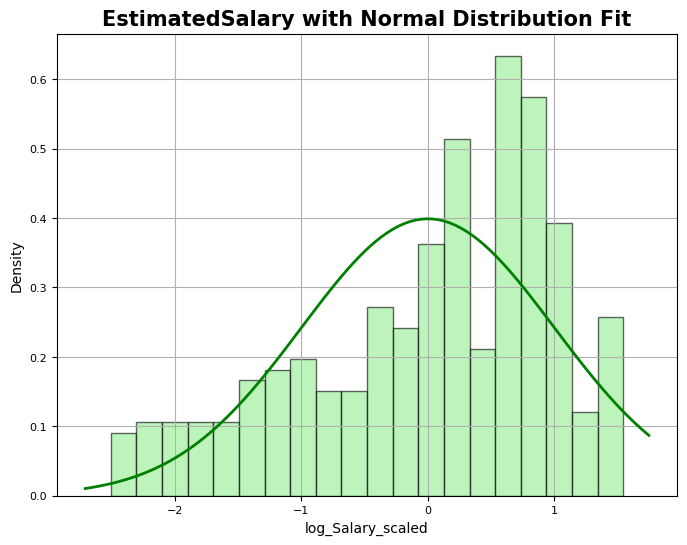

In [18]:
# (2)'EstimatedSalary' 로그 변환 & 스케일링

# 로그 변환 후 표준화
log_salary = np.log1p(df["EstimatedSalary"])  # 로그 변환 (log1p는 log(1 + x))
scaler = StandardScaler()
df["log_Salary_scaled"] = scaler.fit_transform(log_salary.values.reshape(-1, 1))

# 히스토그램 시각화
plt.figure(figsize=(8, 6))
plt.hist(
    df["log_Salary_scaled"],
    bins=20,
    density=True,
    color="lightgreen",
    edgecolor="black",
    alpha=0.6,
)
plt.title(
    "EstimatedSalary with Normal Distribution Fit", fontsize="15", fontweight="bold"
)
plt.xlabel("log_Salary_scaled", fontsize="10")
plt.ylabel("Density", fontsize="10")
plt.grid(True)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 정규 분포 곡선 추가
mu, std = stats.norm.fit(df["log_Salary_scaled"])  # 평균과 표준편차 계산
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2, color="green")

plt.show()

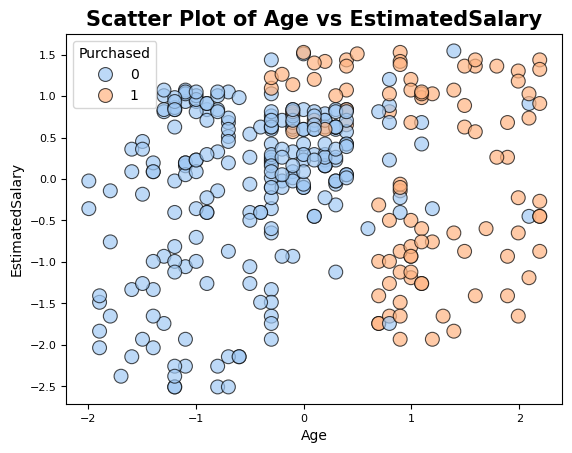

In [42]:
# 산점도 그리기
sns.scatterplot(
    data=df,
    x="Age_scaled",
    y="log_Salary_scaled",
    hue="Purchased",
    palette="pastel",  # 파스텔 색상 설정
    s=100,  # 점의 크기
    edgecolor="k",  # 점의 테두리 색상
    alpha=0.7  # 투명도 설정
)

# 그래프 제목 및 축 레이블 설정
plt.title("Scatter Plot of Age vs EstimatedSalary", fontsize=15, fontweight="bold")
plt.xlabel("Age", fontsize=10)
plt.ylabel("EstimatedSalary", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 그래프 표시
plt.show()

In [20]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_scaled,log_Salary_scaled
0,15624510,0,19,19000,0,-1.891161,-2.034467
1,15810944,0,35,20000,0,-0.298861,-1.932027
2,15668575,1,26,43000,0,-1.194530,-0.403250
3,15603246,1,27,57000,0,-1.095011,0.159666
5,15728773,0,27,58000,0,-1.095011,0.194401


Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\boar2\anaconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\boar2\anaconda3\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\boar2\anaconda3\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 24: invalid start byte
c:\Users\boar2\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
'NoneType' object has no attribute 'splitlines'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\boar2\anaconda3\Lib\site-pack

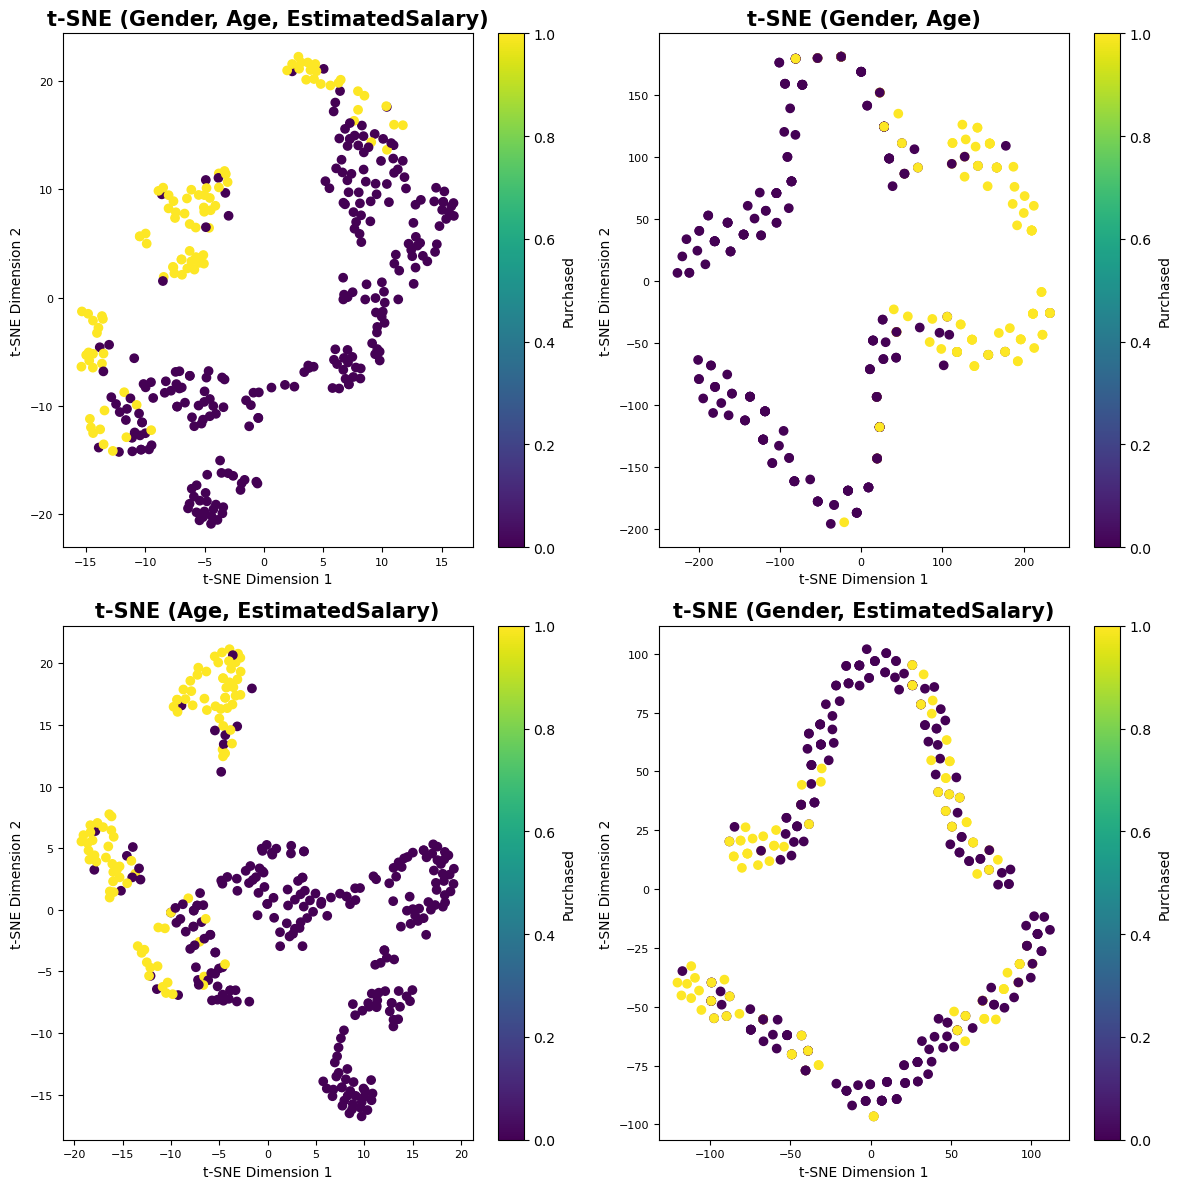

In [21]:
# t-SNE

# 1. Gender, Age_scaled, log_Salary_scaled 피처 사용
features1 = ["Gender", "Age_scaled", "log_Salary_scaled"]
X1 = df[features1].copy()
tsne1 = TSNE(n_components=2, random_state=42)
X_tsne1 = tsne1.fit_transform(X1)

# 2. Gender, Age_scaled 피처 사용
features2 = ["Gender", "Age_scaled"]
X2 = df[features2].copy()
tsne2 = TSNE(n_components=2, random_state=42)
X_tsne2 = tsne2.fit_transform(X2)

# 3. Age_scaled, log_Salary_scaled 피처 사용
features3 = ["Age_scaled", "log_Salary_scaled"]
X3 = df[features3].copy()
tsne3 = TSNE(n_components=2, random_state=42)
X_tsne3 = tsne3.fit_transform(X3)

# 4. Gender, log_Salary_scaled 피처 사용
features4 = ["Gender", "log_Salary_scaled"]
X4 = df[features4].copy()
tsne4 = TSNE(n_components=2, random_state=42)
X_tsne4 = tsne4.fit_transform(X4)

# t-SNE 결과를 한 figure에 네 개의 서브플롯으로 시각화 (2x2 배열)
plt.figure(figsize=(12, 12))

# 첫 번째 서브플롯
plt.subplot(2, 2, 1)
plt.scatter(X_tsne1[:, 0], X_tsne1[:, 1], c=df["Purchased"], cmap="viridis")
plt.colorbar(label="Purchased")
plt.title("t-SNE (Gender, Age, EstimatedSalary)", fontsize=15, fontweight="bold")
plt.xlabel("t-SNE Dimension 1", fontsize=10)
plt.ylabel("t-SNE Dimension 2", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 두 번째 서브플롯
plt.subplot(2, 2, 2)
plt.scatter(X_tsne2[:, 0], X_tsne2[:, 1], c=df["Purchased"], cmap="viridis")
plt.colorbar(label="Purchased")
plt.title("t-SNE (Gender, Age)", fontsize=15, fontweight="bold")
plt.xlabel("t-SNE Dimension 1", fontsize=10)
plt.ylabel("t-SNE Dimension 2", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 세 번째 서브플롯
plt.subplot(2, 2, 3)
plt.scatter(X_tsne3[:, 0], X_tsne3[:, 1], c=df["Purchased"], cmap="viridis")
plt.colorbar(label="Purchased")
plt.title("t-SNE (Age, EstimatedSalary)", fontsize=15, fontweight="bold")
plt.xlabel("t-SNE Dimension 1", fontsize=10)
plt.ylabel("t-SNE Dimension 2", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 네 번째 서브플롯
plt.subplot(2, 2, 4)
plt.scatter(X_tsne4[:, 0], X_tsne4[:, 1], c=df["Purchased"], cmap="viridis")
plt.colorbar(label="Purchased")
plt.title("t-SNE (Gender, EstimatedSalary)", fontsize=15, fontweight="bold")
plt.xlabel("t-SNE Dimension 1", fontsize=10)
plt.ylabel("t-SNE Dimension 2", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

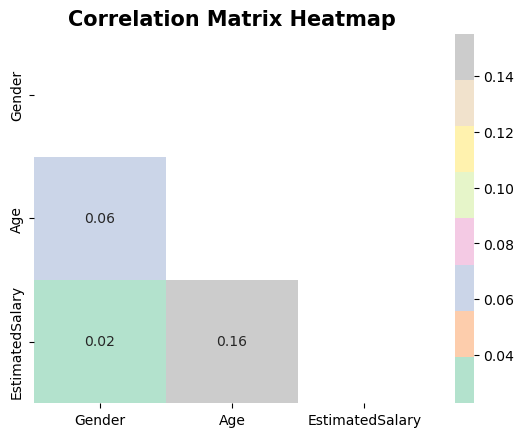

In [22]:
# 히트맵을 그리기 위한 상관관계 행렬 계산 및 시각화

# 상관관계 행렬 계산
correlation_data = df[["Gender", "Age_scaled", "log_Salary_scaled"]].corr()

# 상단 삼각형을 마스크 처리하여 히트맵을 반쪽만 표시
mask = np.triu(np.ones_like(correlation_data, dtype=bool))

sns.heatmap(
    correlation_data, annot=True, cmap="Pastel2", fmt=".2f", mask=mask, cbar=True
)

# X축과 Y축의 라벨 변경
plt.xticks([0.5, 1.5, 2.5], ["Gender", "Age", "EstimatedSalary"], fontsize="10")
plt.yticks([0.5, 1.5, 2.5], ["Gender", "Age", "EstimatedSalary"], fontsize="10")

plt.title("Correlation Matrix Heatmap", fontsize="15", fontweight="bold")
plt.show()

c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

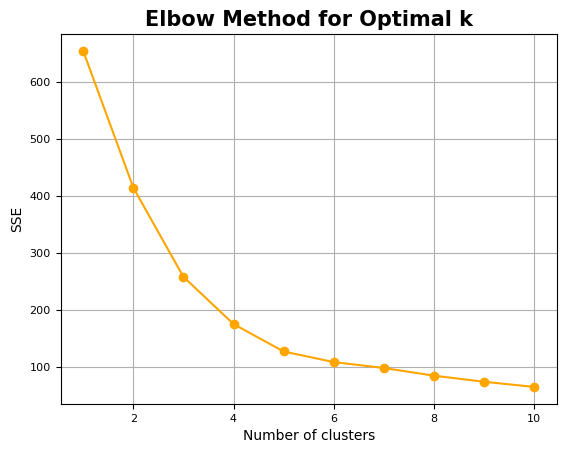

In [23]:
# [3. 클러스터링]

# (1) K-Means 클러스터링
# (1)-1. Elbow Method 통해 최적의 클러스터 수(k) 확인; SSE(Sum of Squared Errors)가 급격히 감소하는 지점

# 'Age_scaled'와 'log_Salary_scaled' 피처 사용
X = df[["Age_scaled", "log_Salary_scaled"]]

# SSE (Sum of Squared Errors) 계산을 위한 리스트
sse = []
k_range = range(1, 11)

# k에 따른 KMeans 클러스터링 수행 및 SSE 저장
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Elbow Method 그래프 "k=3이 베스트(SSE 감소량, 감소율 가장 큼)"
plt.plot(k_range, sse, marker="o", color="orange")
plt.title("Elbow Method for Optimal k", fontsize="15", fontweight="bold")
plt.xlabel("Number of clusters", fontsize="10")
plt.ylabel("SSE", fontsize="10")
plt.grid(True)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

In [24]:
# SSE (Sum of Squared Errors) 계산을 위한 리스트
sse = []
k_range = range(1, 11)

# k에 따른 KMeans 클러스터링 수행 및 SSE 저장
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# 기울기(1차 미분) 계산 "클러스터 수가 증가할 때, SSE의 감소량"
sse_diff = np.diff(sse)  # 각 클러스터 수 증가에 따른 SSE 감소량 계산

# 기울기의 변화(2차 미분) 계산 "기울기의 변화"
sse_diff2 = np.diff(sse_diff)  # 기울기 변화 계산

# 1차 미분과 2차 미분 결과 출력
sse_diff, sse_diff2

c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

(array([-239.78472639, -156.56561672,  -82.7723022 ,  -48.17473106,
         -18.58128045,  -10.3503024 ,  -13.52892406,  -10.6388584 ,
          -9.0765614 ]),
 array([83.21910968, 73.79331452, 34.59757114, 29.59345061,  8.23097804,
        -3.17862166,  2.89006566,  1.562297  ]))

c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

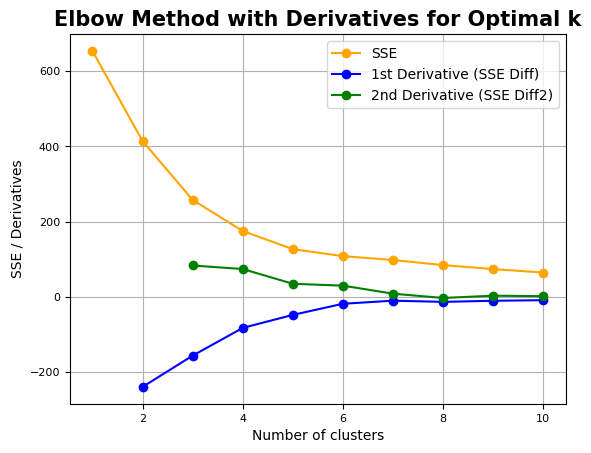

In [25]:
# 'Age_scaled'와 'log_Salary_scaled' 피처 사용
X = df[["Age_scaled", "log_Salary_scaled"]]

# SSE (Sum of Squared Errors) 계산을 위한 리스트
sse = []
k_range = range(1, 11)

# k에 따른 KMeans 클러스터링 수행 및 SSE 저장
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# 기울기(1차 미분) 계산
sse_diff = np.diff(sse)

# 기울기의 변화(2차 미분) 계산
sse_diff2 = np.diff(sse_diff)

# 원본 Elbow Method 그래프
plt.plot(k_range, sse, marker="o", label="SSE", color="orange")

# 1차 미분 (기울기) 그래프 추가
plt.plot(
    k_range[1:], sse_diff, marker="o", label="1st Derivative (SSE Diff)", color="blue"
)

# 2차 미분 (기울기의 변화) 그래프 추가
plt.plot(
    k_range[2:],
    sse_diff2,
    marker="o",
    label="2nd Derivative (SSE Diff2)",
    color="green",
)

plt.title(
    "Elbow Method with Derivatives for Optimal k", fontsize="15", fontweight="bold"
)
plt.xlabel("Number of clusters", fontsize="10")
plt.ylabel("SSE / Derivatives", fontsize="10")
plt.legend()
plt.grid(True)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

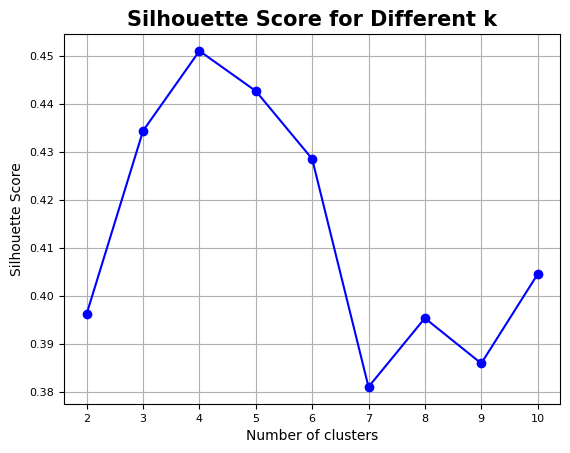

[(2, 0.39624243555761085),
 (3, 0.4343358154643224),
 (4, 0.4509777314775494),
 (5, 0.4426280983657006),
 (6, 0.42848854962345545),
 (7, 0.3809993753989256),
 (8, 0.39531940694641243),
 (9, 0.38589902208555266),
 (10, 0.40446530868030867)]

In [26]:
# (1)-2. 실루엣 점수(Silhouette Score) 통해 최적의 클러스터 수(k) 확인; 점수(-1~1)가 높을 수록 클러스터링 품질이 좋음

# 여러 개의 클러스터 수에 대해 K-Means 클러스터링을 수행하고 실루엣 점수를 계산
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X)
    score = silhouette_score(X, clusters)
    silhouette_scores.append(score)

# 실루엣 점수 시각화 "k=6이 베스트(최고점)"
plt.plot(k_range, silhouette_scores, marker="o", color="blue")
plt.title("Silhouette Score for Different k", fontsize="15", fontweight="bold")
plt.xlabel("Number of clusters", fontsize="10")
plt.ylabel("Silhouette Score", fontsize="10")
plt.grid(True)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

# 각 클러스터 수에 따른 실루엣 점수 확인
list(zip(k_range, silhouette_scores))

c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

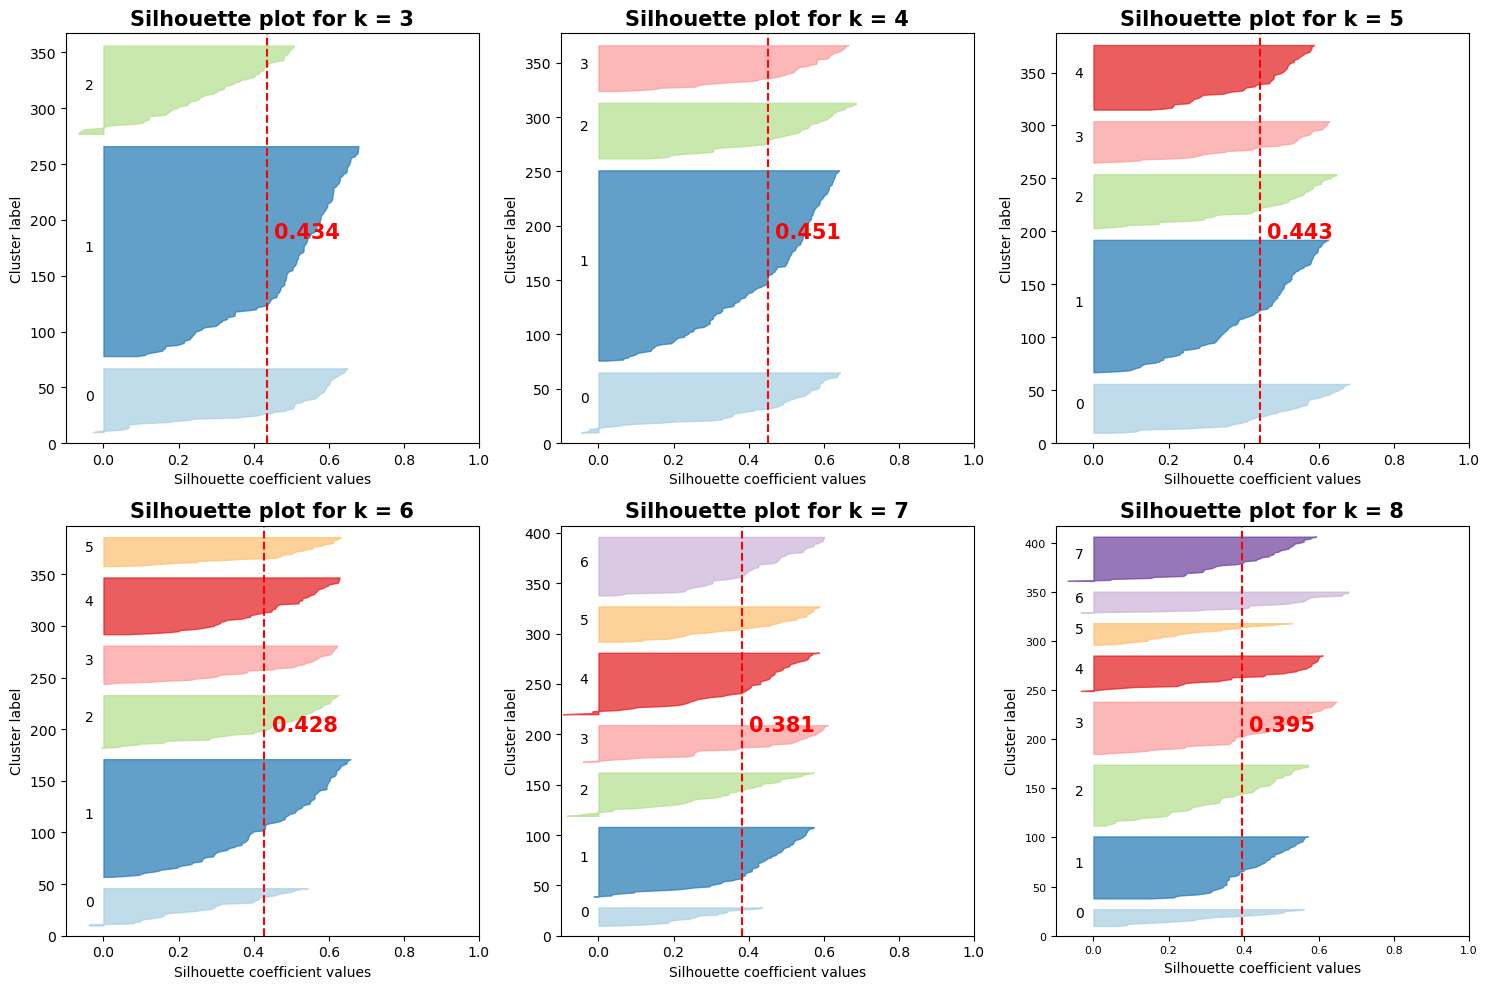

In [27]:
# 서브플롯 설정 (k=3부터)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

# 파스텔 색상 설정
pastel_colors = cm.Paired(np.linspace(0, 1, 10))

# k=3부터 k=8까지 시각화
for idx, k in enumerate(range(3, 9)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, clusters)

    # 각 샘플의 실루엣 점수 계산
    sample_silhouette_values = silhouette_samples(X, clusters)

    y_lower = 10
    axs[idx].set_xlim([-0.1, 1])
    axs[idx].set_ylim([0, len(X) + (k + 1) * 10])

    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = pastel_colors[i % len(pastel_colors)]
        axs[idx].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        axs[idx].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    axs[idx].axvline(x=silhouette_avg, color="red", linestyle="--")
    # 실루엣 계수를 점선 오른쪽에 빨간색으로 표시
    axs[idx].text(
        silhouette_avg + 0.02,
        y_lower / 2,
        f"{silhouette_avg:.3f}",
        color="red",
        fontsize=15,
        fontweight="bold",
    )

    axs[idx].set_title(f"Silhouette plot for k = {k}", fontsize="15", fontweight="bold")
    axs[idx].set_xlabel("Silhouette coefficient values", fontsize="10")
    axs[idx].set_ylabel("Cluster label", fontsize="10")

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


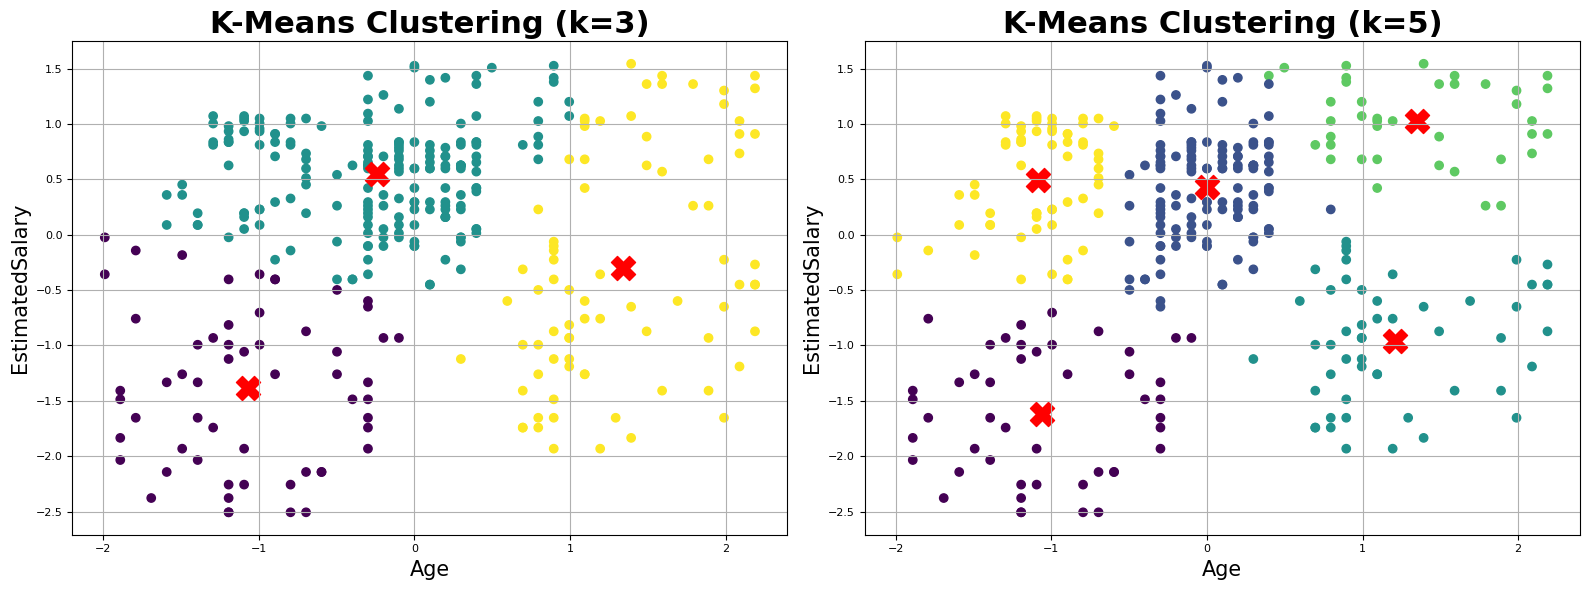

In [28]:
# (1)-2. K-Means 클러스터링 수행 (k=3) 및 (k=5) 결과를 하나의 figure에 표시

# Figure 및 서브플롯 설정
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# K=3으로 클러스터링 수행
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
clusters_k3 = kmeans_k3.fit_predict(df[["Age_scaled", "log_Salary_scaled"]])

# 첫 번째 서브플롯 (k=3)
axs[0].scatter(
    df["Age_scaled"],
    df["log_Salary_scaled"],
    c=clusters_k3,
    cmap="viridis",
    marker="o",
)
axs[0].scatter(
    kmeans_k3.cluster_centers_[:, 0],
    kmeans_k3.cluster_centers_[:, 1],
    s=300,
    c="red",
    marker="X",
)  # 클러스터 중심 표시
axs[0].set_title("K-Means Clustering (k=3)", fontsize="22", fontweight="bold")
axs[0].set_xlabel("Age", fontsize="15")
axs[0].set_ylabel("EstimatedSalary", fontsize="15")
axs[0].grid(True)
axs[0].tick_params(axis="both", which="major", labelsize=8)

# K=5으로 클러스터링 수행
kmeans_k5 = KMeans(n_clusters=5, random_state=42)
clusters_k5 = kmeans_k5.fit_predict(df[["Age_scaled", "log_Salary_scaled"]])

# 두 번째 서브플롯 (k=5)
axs[1].scatter(
    df["Age_scaled"],
    df["log_Salary_scaled"],
    c=clusters_k5,
    cmap="viridis",
    marker="o",
)
axs[1].scatter(
    kmeans_k5.cluster_centers_[:, 0],
    kmeans_k5.cluster_centers_[:, 1],
    s=300,
    c="red",
    marker="X",
)  # 클러스터 중심 표시
axs[1].set_title("K-Means Clustering (k=5)", fontsize="22", fontweight="bold")
axs[1].set_xlabel("Age", fontsize="15")
axs[1].set_ylabel("EstimatedSalary", fontsize="15")
axs[1].grid(True)
axs[1].tick_params(axis="both", which="major", labelsize=8)

plt.tight_layout()
plt.show()

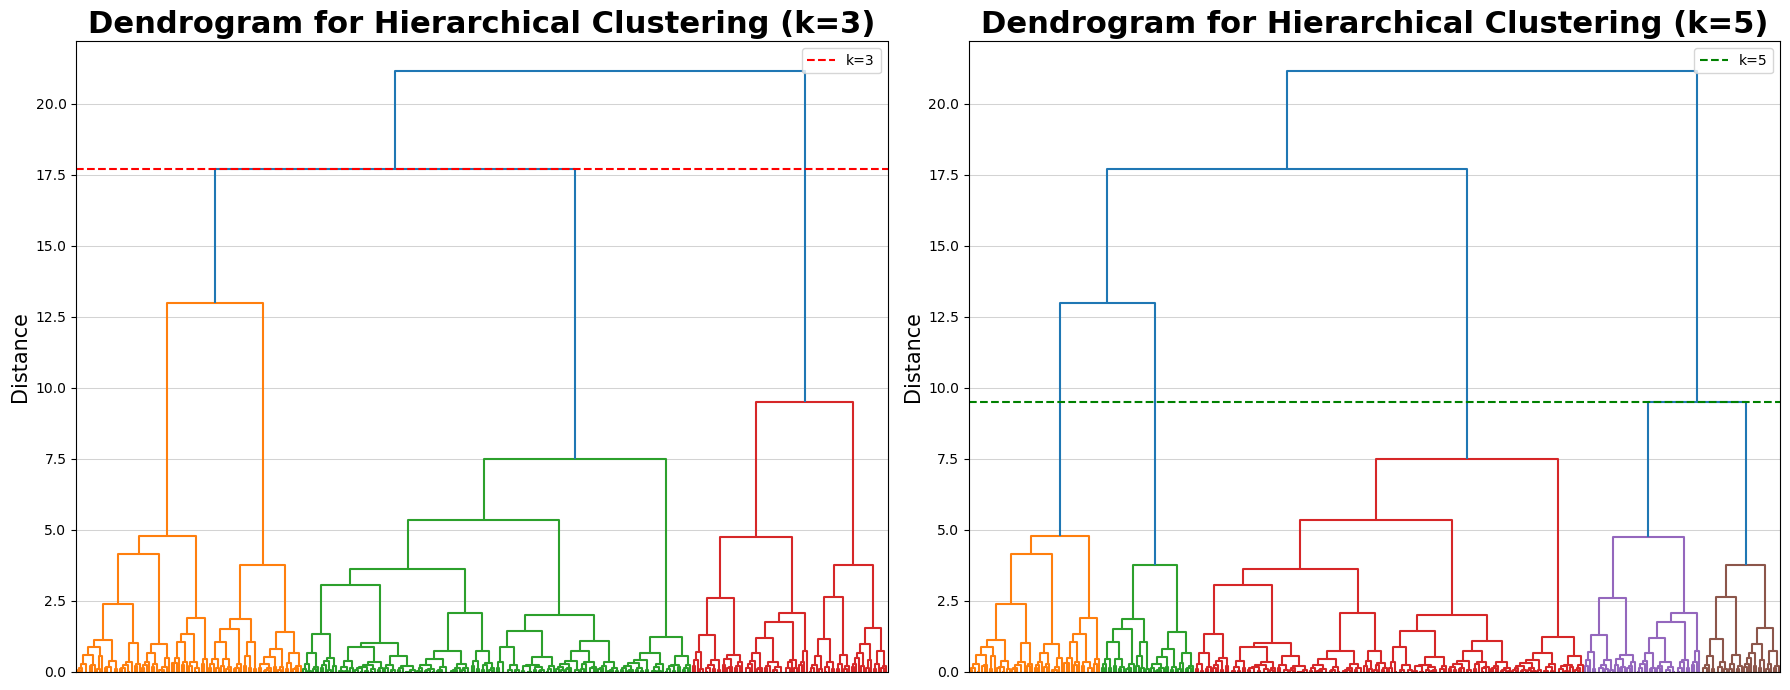

In [29]:
# 계층적 클러스터링 수행
linked = linkage(X, method="ward")

# Figure 및 2개의 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# k=3 클러스터링 수행 및 덴드로그램 시각화
clusters_k3 = fcluster(linked, 3, criterion="maxclust")

# k=3 덴드로그램 시각화
axs[0].set_title(
    "Dendrogram for Hierarchical Clustering (k=3)", fontsize="22", fontweight="bold"
)
dendrogram(
    linked,
    orientation="top",
    distance_sort="descending",
    show_leaf_counts=False,
    labels=None,
    ax=axs[0],
    color_threshold=linked[-(3 - 1), 2],  # k=3에 해당하는 색상 기준
)
axs[0].axhline(y=linked[-(3 - 1), 2], color="r", linestyle="--", label="k=3")
axs[0].legend()
axs[0].set_ylabel("Distance", fontsize="15")

# x축 눈금만 남기고 세로 눈금 제거
axs[0].grid(
    True, which="major", axis="y", linestyle="-", linewidth=0.75, color="lightgray"
)
axs[0].grid(False, axis="x")  # x축 눈금 제거

# x축 라벨 제거
axs[0].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

# k=5 클러스터링 수행 및 덴드로그램 시각화
clusters_k5 = fcluster(linked, 5, criterion="maxclust")

# k=5 덴드로그램 시각화
axs[1].set_title(
    "Dendrogram for Hierarchical Clustering (k=5)", fontsize="22", fontweight="bold"
)
dendrogram(
    linked,
    orientation="top",
    distance_sort="descending",
    show_leaf_counts=False,
    labels=None,
    ax=axs[1],
    color_threshold=linked[-(5 - 1), 2],  # k=5에 해당하는 색상 기준
)
axs[1].axhline(y=linked[-(5 - 1), 2], color="g", linestyle="--", label="k=5")
axs[1].legend()
axs[1].set_ylabel("Distance", fontsize="15")

# x축 눈금만 남기고 세로 눈금 제거
axs[1].grid(
    True, which="major", axis="y", linestyle="-", linewidth=0.75, color="lightgray"
)
axs[1].grid(False, axis="x")  # x축 눈금 제거

# x축 라벨 제거
axs[1].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

plt.tight_layout()
plt.show()

c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


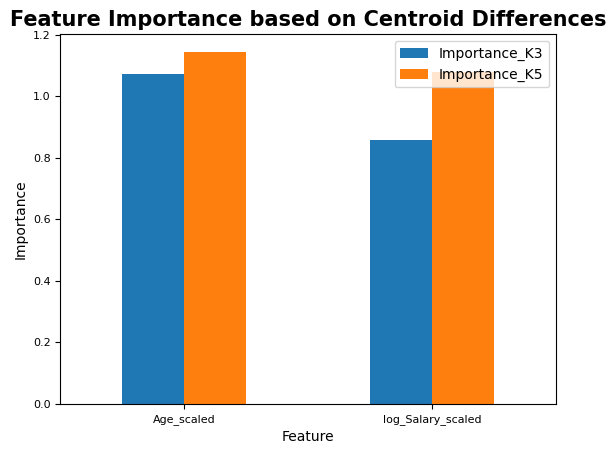

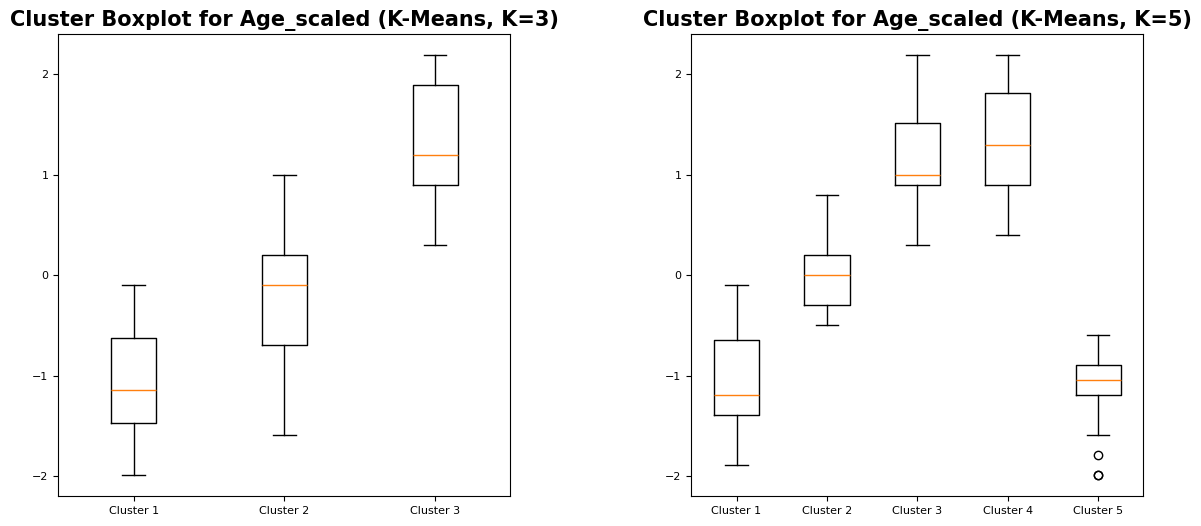

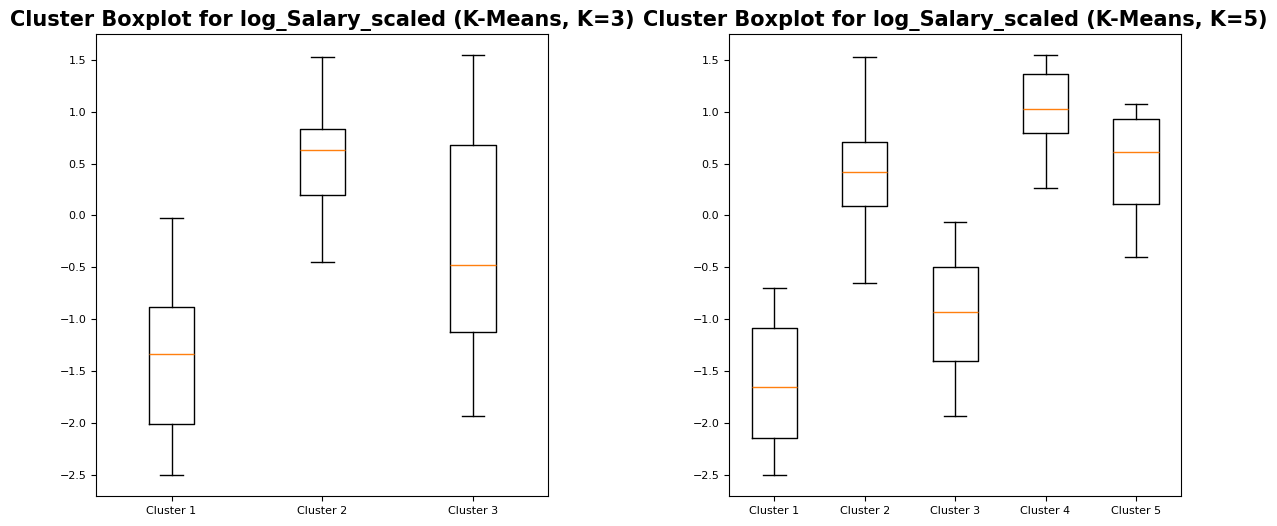

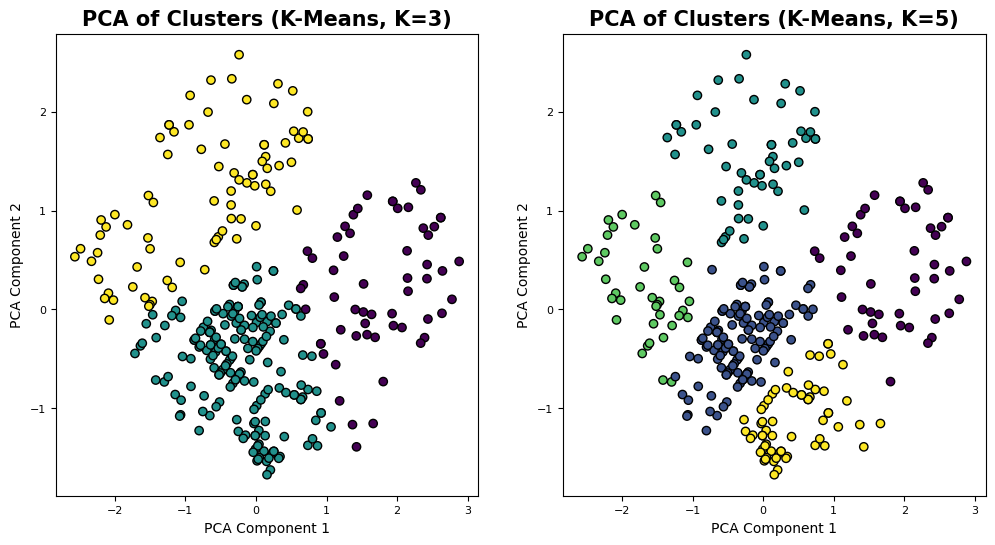

In [30]:
# (3) 피처 중요도 확인
"""
1. Centroid Differences : 각 클러스터의 중심(센트로이드) 간의 차이를 기반으로 피처들의 중요도를 시각화. 각 피처가 클러스터 형성에 얼마나 중요한지를 명확하게 보여줌. 중요한 피처일수록 클러스터 중심 간의 차이가 더 크게 나타나며, 이로 인해 해당 피처가 클러스터 형성에 더 많이 기여했다는 것을 알 수 있음
2. 박스플롯 : 각 클러스터에 대해 개별 피처의 분포를 시각화.박스플롯에서 클러스터 간 특정 피처의 분포 차이가 클수록, 해당 피처가 클러스터 구분에서 중요한 역할을 했다고 판단
3. PCA : PCA로 축소된 2차원 혹은 3차원 공간에서 클러스터가 어떻게 분포하는지를 시각화함으로써, 특정 피처들이 클러스터를 구분하는 데 얼마나 중요한지를 간접적으로 확인. 예를 들어, PCA 시각화에서 클러스터가 잘 구분된다면, PCA에서 가장 큰 기여를 한 피처들이 중요하다고 판단
"""

# K=3, K=5으로 클러스터링 수행
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
clusters_k3 = kmeans_k3.fit_predict(df[["Age_scaled", "log_Salary_scaled"]])

kmeans_k5 = KMeans(n_clusters=5, random_state=42)
clusters_k5 = kmeans_k5.fit_predict(df[["Age_scaled", "log_Salary_scaled"]])

# 클러스터 중심 확인
centroids_k3 = kmeans_k3.cluster_centers_
centroids_k5 = kmeans_k5.cluster_centers_

# 각 클러스터 센트로이드 간의 차이 계산
diff_k3 = np.abs(centroids_k3[None, :, :] - centroids_k3[:, None, :])
diff_k5 = np.abs(centroids_k5[None, :, :] - centroids_k5[:, None, :])

# 피처별 평균 차이 계산 (중요도 추정)
importance_k3 = np.mean(diff_k3, axis=(0, 1))
importance_k5 = np.mean(diff_k5, axis=(0, 1))

# 피처 중요도를 DataFrame으로 정리
importance_df = pd.DataFrame(
    {
        "Feature": ["Age_scaled", "log_Salary_scaled"],
        "Importance_K3": importance_k3,
        "Importance_K5": importance_k5,
    }
)

# 피처 중요도 시각화
importance_df.set_index("Feature").plot(kind="bar")
plt.title(
    "Feature Importance based on Centroid Differences", fontsize="15", fontweight="bold"
)
plt.ylabel("Importance", fontsize="10")
plt.xticks(fontsize=8, rotation=0)
plt.yticks(fontsize=8)

plt.show()

# 클러스터별 박스플롯
for i, feature in enumerate(["Age_scaled", "log_Salary_scaled"]):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1행 2열의 서브플롯 생성

    # 첫 번째 서브플롯 (k=3)
    axes[0].boxplot(
        [df[clusters_k3 == j][feature] for j in range(3)],
        labels=[f"Cluster {j+1}" for j in range(3)],
    )
    axes[0].set_title(
        f"Cluster Boxplot for {feature} (K-Means, K=3)",
        fontsize=15,
        fontweight="bold",
    )

    # 두 번째 서브플롯 (k=5)
    axes[1].boxplot(
        [df[clusters_k5 == j][feature] for j in range(5)],
        labels=[f"Cluster {j+1}" for j in range(5)],
    )
    axes[1].set_title(
        f"Cluster Boxplot for {feature} (K-Means, K=5)",
        fontsize=15,
        fontweight="bold",
    )

    # x축, y축 폰트 크기 조정
    for ax in axes:
        ax.tick_params(axis="x", labelsize=8)
        ax.tick_params(axis="y", labelsize=8)

    # 서브플롯 간의 간격 조정
    plt.subplots_adjust(wspace=0.4)  # 수평 간격을 넓힘

    plt.show()

# PCA 시각화
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df[["Age_scaled", "log_Salary_scaled"]])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(
    pca_components[:, 0],
    pca_components[:, 1],
    c=clusters_k3,
    cmap="viridis",
    marker="o",
    edgecolor="k",
)
plt.title("PCA of Clusters (K-Means, K=3)", fontsize="15", fontweight="bold")
plt.xlabel("PCA Component 1", fontsize="10")
plt.ylabel("PCA Component 2", fontsize="10")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.subplot(1, 2, 2)
plt.scatter(
    pca_components[:, 0],
    pca_components[:, 1],
    c=clusters_k5,
    cmap="viridis",
    marker="o",
    edgecolor="k",
)
plt.title("PCA of Clusters (K-Means, K=5)", fontsize="15", fontweight="bold")
plt.xlabel("PCA Component 1", fontsize="10")
plt.ylabel("PCA Component 2", fontsize="10")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

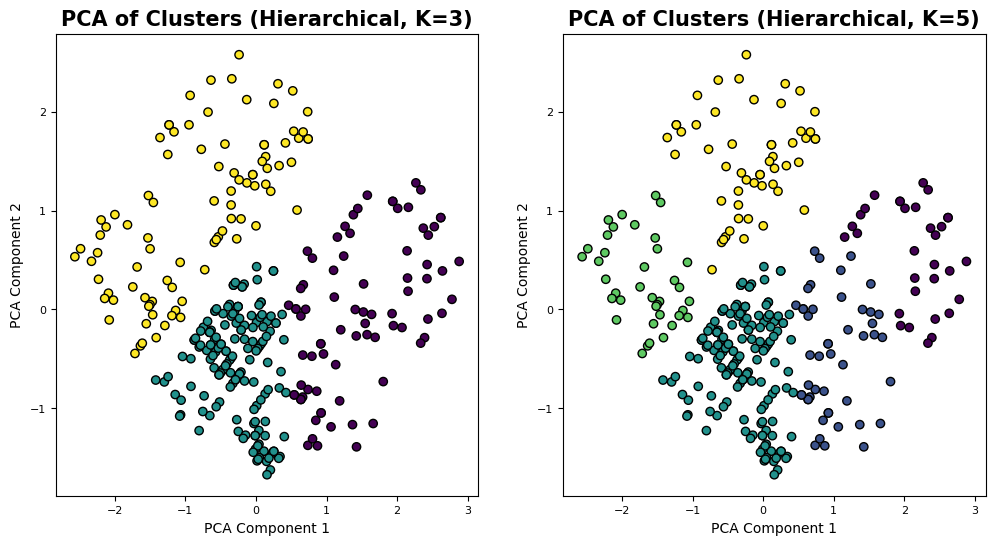

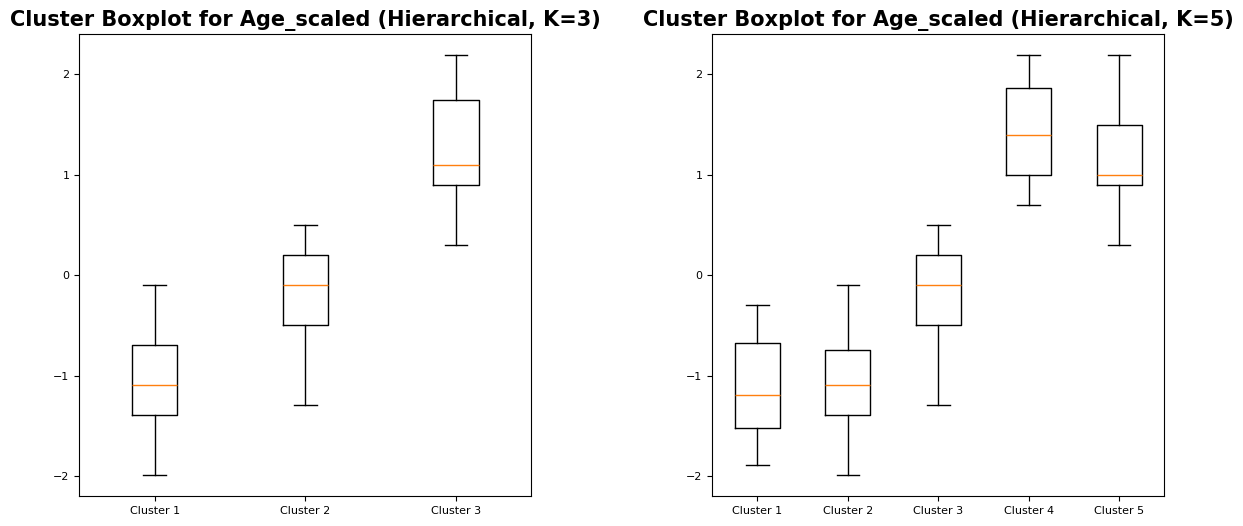

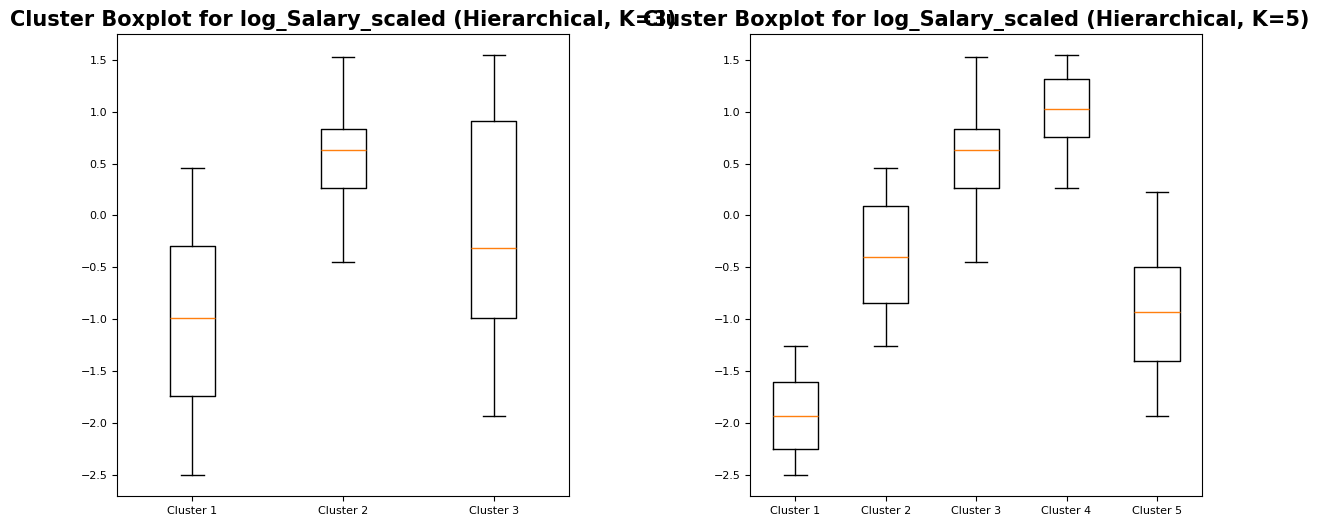

In [31]:
# (3)-2. Hierarchical 클러스터링의 피처 중요도
# (하이어라키에서는 직접적인 계산이 어려워 PCA와 같은 간접적 방법 사용 가능)

# 계층적 클러스터링 수행 (이전에 수행된 경우 생략 가능)
linked = linkage(df[["Age_scaled", "log_Salary_scaled"]], method="ward")

# K=3, K=5으로 클러스터링 수행
clusters_k3 = fcluster(linked, 3, criterion="maxclust")
clusters_k5 = fcluster(linked, 5, criterion="maxclust")

# PCA 시각화
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df[["Age_scaled", "log_Salary_scaled"]])

plt.figure(figsize=(12, 6))

# K=3 클러스터링 결과 시각화
plt.subplot(1, 2, 1)
plt.scatter(
    pca_components[:, 0],
    pca_components[:, 1],
    c=clusters_k3,
    cmap="viridis",
    marker="o",
    edgecolor="k",
)
plt.title("PCA of Clusters (Hierarchical, K=3)", fontsize="15", fontweight="bold")
plt.xlabel("PCA Component 1", fontsize="10")
plt.ylabel("PCA Component 2", fontsize="10")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# K=5 클러스터링 결과 시각화
plt.subplot(1, 2, 2)
plt.scatter(
    pca_components[:, 0],
    pca_components[:, 1],
    c=clusters_k5,
    cmap="viridis",
    marker="o",
    edgecolor="k",
)
plt.title("PCA of Clusters (Hierarchical, K=5)", fontsize="15", fontweight="bold")
plt.xlabel("PCA Component 1", fontsize="10")
plt.ylabel("PCA Component 2", fontsize="10")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

# 클러스터별 박스플롯
for feature in ["Age_scaled", "log_Salary_scaled"]:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1행 2열의 서브플롯 생성

    # 첫 번째 서브플롯 (K=3)
    axes[0].boxplot(
        [df[clusters_k3 == j][feature] for j in range(1, 4)],
        labels=[f"Cluster {j}" for j in range(1, 4)],
    )
    axes[0].set_title(
        f"Cluster Boxplot for {feature} (Hierarchical, K=3)",
        fontsize=15,
        fontweight="bold",
    )

    # 두 번째 서브플롯 (K=5)
    axes[1].boxplot(
        [df[clusters_k5 == j][feature] for j in range(1, 6)],
        labels=[f"Cluster {j}" for j in range(1, 6)],
    )
    axes[1].set_title(
        f"Cluster Boxplot for {feature} (Hierarchical, K=5)",
        fontsize=15,
        fontweight="bold",
    )

    # x축, y축 폰트 크기 조정
    for ax in axes:
        ax.tick_params(axis="x", labelsize=8)
        ax.tick_params(axis="y", labelsize=8)

    # 서브플롯 간의 간격 조정
    plt.subplots_adjust(wspace=0.4)  # 수평 간격을 넓힘

    plt.show()

In [32]:
"""
* 세 가지 주요 피처(나이, 성별, 로그 변환된 추정 급여)의 클러스터별 분포 해석
1. 나이(왼쪽 그래프):
- 클러스터 0: 나이의 중앙값이 약 30대 중반이며, 분포 범위는 20대 후반에서 40대 초반까지로 보입니다. 이 클러스터는 비교적 젊은 연령층으로 구성
- 클러스터 1: 중앙값이 약 50대 초반으로, 나이 분포가 40대 후반에서 60대 초반까지입니다. 이 클러스터는 중년층으로 구성된 것으로 해석됨
- 클러스터 2: 중앙값이 약 30대 초반으로, 20대에서 40대 초반까지의 분포를 보입니다. 클러스터 0과 비슷하지만 조금 더 젊은 연령층일 가능성이 있음

2. 성별(가운데 그래프):
- 모든 클러스터에서 성별 비율은 동일하게 나타남. 이는 클러스터링에서 성별이 큰 영향을 미치지 않았거나, 성별이 클러스터를 나누는 데 있어 중요한 변수가 아니었음을 시사함

3. 로그 변환된 추정 급여(오른쪽 그래프):
- 클러스터 0: 중앙값이 약 11.1로, 로그 변환된 급여가 비교적 높은 수준에서 분포
- 클러스터 1: 중앙값이 약 11.4로, 가장 높은 급여를 가지는 클러스터
- 클러스터 2: 중앙값이 약 10.7로, 다른 클러스터에 비해 상대적으로 낮은 급여 수준을 보임

** 종합 해석:
- 클러스터 0: 젊은 층(30대 중반)으로, 중간 정도의 급여 수준
- 클러스터 1: 중년층(50대 초반)으로, 가장 높은 급여 수준
- 클러스터 2: 비교적 젊은 층(30대 초반)으로, 급여 수준이 가장 낮음
- 성별은 클러스터를 나누는 데 있어 주요한 역할을 하지 않았으며, 나이와 급여가 클러스터링에서 중요한 피처였음을 알 수 있습니다. 이를 바탕으로 각 클러스터에 속한 그룹의 특징을 정의할 수 있을 것
"""

'\n* 세 가지 주요 피처(나이, 성별, 로그 변환된 추정 급여)의 클러스터별 분포 해석\n1. 나이(왼쪽 그래프):\n- 클러스터 0: 나이의 중앙값이 약 30대 중반이며, 분포 범위는 20대 후반에서 40대 초반까지로 보입니다. 이 클러스터는 비교적 젊은 연령층으로 구성\n- 클러스터 1: 중앙값이 약 50대 초반으로, 나이 분포가 40대 후반에서 60대 초반까지입니다. 이 클러스터는 중년층으로 구성된 것으로 해석됨\n- 클러스터 2: 중앙값이 약 30대 초반으로, 20대에서 40대 초반까지의 분포를 보입니다. 클러스터 0과 비슷하지만 조금 더 젊은 연령층일 가능성이 있음\n\n2. 성별(가운데 그래프):\n- 모든 클러스터에서 성별 비율은 동일하게 나타남. 이는 클러스터링에서 성별이 큰 영향을 미치지 않았거나, 성별이 클러스터를 나누는 데 있어 중요한 변수가 아니었음을 시사함\n\n3. 로그 변환된 추정 급여(오른쪽 그래프):\n- 클러스터 0: 중앙값이 약 11.1로, 로그 변환된 급여가 비교적 높은 수준에서 분포\n- 클러스터 1: 중앙값이 약 11.4로, 가장 높은 급여를 가지는 클러스터\n- 클러스터 2: 중앙값이 약 10.7로, 다른 클러스터에 비해 상대적으로 낮은 급여 수준을 보임\n\n** 종합 해석:\n- 클러스터 0: 젊은 층(30대 중반)으로, 중간 정도의 급여 수준\n- 클러스터 1: 중년층(50대 초반)으로, 가장 높은 급여 수준\n- 클러스터 2: 비교적 젊은 층(30대 초반)으로, 급여 수준이 가장 낮음\n- 성별은 클러스터를 나누는 데 있어 주요한 역할을 하지 않았으며, 나이와 급여가 클러스터링에서 중요한 피처였음을 알 수 있습니다. 이를 바탕으로 각 클러스터에 속한 그룹의 특징을 정의할 수 있을 것\n'

In [33]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_scaled,log_Salary_scaled
0,15624510,0,19,19000,0,-1.891161,-2.034467
1,15810944,0,35,20000,0,-0.298861,-1.932027
2,15668575,1,26,43000,0,-1.194530,-0.403250
3,15603246,1,27,57000,0,-1.095011,0.159666
5,15728773,0,27,58000,0,-1.095011,0.194401


In [34]:
# (1) K-Means

# K-Means 클러스터링 수행
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
clusters_k3 = kmeans_k3.fit_predict(df[["Age_scaled", "log_Salary_scaled"]])
df["Cluster_K3"] = clusters_k3

kmeans_k5 = KMeans(n_clusters=5, random_state=42)
clusters_k5 = kmeans_k5.fit_predict(df[["Age_scaled", "log_Salary_scaled"]])
df["Cluster_K5"] = clusters_k5


# 신뢰구간 계산 함수 정의
def calculate_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    mean = np.mean(data)
    sem = stats.sem(data)  # 표준 오차 계산
    margin_of_error = sem * stats.t.ppf((1 + confidence) / 2.0, len(data) - 1)
    return mean, mean - margin_of_error, mean + margin_of_error


# 클러스터별 원본 데이터 값 계산 함수
def calculate_cluster_summary_from_original(df, cluster_col):
    summary = (
        df.groupby(cluster_col)
        .agg(
            {
                "Age": ["mean", "median", "min", "max"],
                "EstimatedSalary": ["mean", "median", "min", "max"],
                "Purchased": "mean",
            }
        )
        .reset_index()
    )

    # 클러스터 크기 계산
    cluster_sizes = df[cluster_col].value_counts().reset_index()
    cluster_sizes.columns = [cluster_col, "Cluster_Size"]

    # 신뢰구간 계산 추가
    confidence_intervals = (
        df.groupby(cluster_col)["Purchased"]
        .apply(calculate_confidence_interval)
        .apply(pd.Series)
    )
    confidence_intervals.columns = ["Purchase_Rate", "CI_Lower", "CI_Upper"]

    # 컬럼 이름 변경
    summary.columns = [
        cluster_col,
        "Age_Mean",
        "Age_Median",
        "Age_Min",
        "Age_Max",
        "Salary_Mean",
        "Salary_Median",
        "Salary_Min",
        "Salary_Max",
        "Purchase_Rate",
    ]

    # 클러스터 크기와 신뢰구간 추가
    summary = summary.merge(cluster_sizes, on=cluster_col)
    summary = summary.merge(confidence_intervals, left_on=cluster_col, right_index=True)

    # 소수점 둘째 자리까지 반올림
    summary = summary.round(2)

    return summary


# 클러스터링 결과 요약 (K=3)
cluster_summary_k3 = calculate_cluster_summary_from_original(df, "Cluster_K3")
print("K=3 클러스터링 결과:")
print(cluster_summary_k3)

# 클러스터링 결과 요약 (K=5)
cluster_summary_k5 = calculate_cluster_summary_from_original(df, "Cluster_K5")
print("\nK=5 클러스터링 결과:")
print(cluster_summary_k5)

K=3 클러스터링 결과:
   Cluster_K3  Age_Mean  Age_Median  Age_Min  Age_Max  Salary_Mean  \
0           0     27.24        26.5       18       37     28034.48   
1           1     35.59        37.0       22       48     71095.24   
2           2     51.50        50.0       41       60     51875.00   

   Salary_Median  Salary_Min  Salary_Max  Purchase_Rate_x  Cluster_Size  \
0        27000.0       15000       52000             0.00            58   
1        72000.0       42000      113000             0.14           189   
2        41500.0       20000      114000             0.85            80   

   Purchase_Rate_y  CI_Lower  CI_Upper  
0             0.00      0.00      0.00  
1             0.14      0.09      0.19  
2             0.85      0.77      0.93  

K=5 클러스터링 결과:
   Cluster_K5  Age_Mean  Age_Median  Age_Min  Age_Max  Salary_Mean  \
0           0     27.36        26.0       19       37     24297.87   
1           1     38.03        38.0       33       46     67150.79   
2           2  

c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [35]:
# K-Means 클러스터링 (k=3)
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
clusters_k3 = kmeans_k3.fit_predict(df[["Age_scaled", "log_Salary_scaled"]])

# 클러스터 번호를 원래 데이터프레임에 추가
df["Cluster_K3"] = clusters_k3

# 클러스터 중심과 크기 계산
cluster_centers_k3 = kmeans_k3.cluster_centers_

# 클러스터 중심값을 포함한 데이터프레임 생성
cluster_summary_k3 = pd.DataFrame(
    cluster_centers_k3, columns=["Age_center", "log_Salary_center"]
)

# 클러스터 ID 추가
cluster_summary_k3["Cluster"] = range(len(cluster_summary_k3))

# 클러스터별 평균 계산 (Age_scaled, log_Salary_scaled)
cluster_means_k3 = (
    df.groupby("Cluster_K3")[["Age_scaled", "log_Salary_scaled"]].mean().reset_index()
)

# 'Cluster_K3' 열을 'Cluster'로 이름 변경 (비교 작업을 위해)
cluster_means_k3.rename(columns={"Cluster_K3": "Cluster"}, inplace=True)

# 클러스터 중심값과 비교
comparison_k3 = cluster_summary_k3.merge(
    cluster_means_k3, on="Cluster", suffixes=("_center", "_mean")
)

# 소수점 둘째 자리까지 반올림
comparison_k3 = comparison_k3.round(2)

print("K=3 클러스터 중심값과 평균값 비교:")
print(comparison_k3)

# 동일한 방식으로 K=5 클러스터링 결과도 비교
kmeans_k5 = KMeans(n_clusters=5, random_state=42)
clusters_k5 = kmeans_k5.fit_predict(df[["Age_scaled", "log_Salary_scaled"]])
df["Cluster_K5"] = clusters_k5

cluster_centers_k5 = kmeans_k5.cluster_centers_
cluster_summary_k5 = pd.DataFrame(
    cluster_centers_k5, columns=["Age_center", "log_Salary_center"]
)
cluster_summary_k5["Cluster"] = range(len(cluster_summary_k5))

cluster_means_k5 = (
    df.groupby("Cluster_K5")[["Age_scaled", "log_Salary_scaled"]].mean().reset_index()
)
cluster_means_k5.rename(columns={"Cluster_K5": "Cluster"}, inplace=True)

comparison_k5 = cluster_summary_k5.merge(
    cluster_means_k5, on="Cluster", suffixes=("_center", "_mean")
)

# 소수점 둘째 자리까지 반올림
comparison_k5 = comparison_k5.round(2)

print("\nK=5 클러스터 중심값과 평균값 비교:")
print(comparison_k5)

c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K=3 클러스터 중심값과 평균값 비교:
   Age_center  log_Salary_center  Cluster  Age_scaled  log_Salary_scaled
0       -1.07              -1.38        0       -1.07              -1.38
1       -0.24               0.55        1       -0.24               0.55
2        1.34              -0.30        2        1.34              -0.30

K=5 클러스터 중심값과 평균값 비교:
   Age_center  log_Salary_center  Cluster  Age_scaled  log_Salary_scaled
0       -1.06              -1.62        0       -1.06              -1.62
1        0.00               0.43        1        0.00               0.43
2        1.21              -0.96        2        1.21              -0.96
3        1.35               1.03        3        1.35               1.03
4       -1.09               0.49        4       -1.09               0.49


c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [36]:
# K=3 클러스터에 대한 클러스터 크기 균일성, 클러스터 내 분산, 클러스터 간 거리 계산
cluster_sizes_k3 = np.bincount(clusters_k3)
cluster_size_std_k3 = np.std(cluster_sizes_k3)

# 클러스터 내 분산 (Within-Cluster Sum of Squares, WCSS) 계산
wcss_k3 = kmeans_k3.inertia_

# 클러스터 간 거리 계산
cluster_centers_k3 = kmeans_k3.cluster_centers_
distances_k3 = np.linalg.norm(
    cluster_centers_k3[:, np.newaxis] - cluster_centers_k3, axis=2
)
min_cluster_distance_k3 = np.min(distances_k3[np.nonzero(distances_k3)])

# K=5 클러스터에 대한 클러스터 크기 균일성, 클러스터 내 분산, 클러스터 간 거리 계산
kmeans_k5 = KMeans(n_clusters=5, random_state=42)
clusters_k5 = kmeans_k5.fit_predict(df[["Age_scaled", "log_Salary_scaled"]])

cluster_sizes_k5 = np.bincount(clusters_k5)
cluster_size_std_k5 = np.std(cluster_sizes_k5)

# 클러스터 내 분산 (Within-Cluster Sum of Squares, WCSS) 계산
wcss_k5 = kmeans_k5.inertia_

# 클러스터 간 거리 계산
cluster_centers_k5 = kmeans_k5.cluster_centers_
distances_k5 = np.linalg.norm(
    cluster_centers_k5[:, np.newaxis] - cluster_centers_k5, axis=2
)
min_cluster_distance_k5 = np.min(distances_k5[np.nonzero(distances_k5)])

# 결과 출력 (소수점 둘째 자리까지)
print("K-Means K=3 Results:")
print(f"1. Cluster Size Standard Deviation (균일성): {cluster_size_std_k3:.2f}")
print(f"2. Within-Cluster Sum of Squares (WCSS): {wcss_k3:.2f}")
print(f"3. Minimum Cluster Distance (클러스터 간 거리): {min_cluster_distance_k3:.2f}")

print("\nK-Means K=5 Results:")
print(f"1. Cluster Size Standard Deviation (균일성): {cluster_size_std_k5:.2f}")
print(f"2. Within-Cluster Sum of Squares (WCSS): {wcss_k5:.2f}")
print(f"3. Minimum Cluster Distance (클러스터 간 거리): {min_cluster_distance_k5:.2f}")

c:\Users\boar2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K-Means K=3 Results:
1. Cluster Size Standard Deviation (균일성): 57.28
2. Within-Cluster Sum of Squares (WCSS): 257.65
3. Minimum Cluster Distance (클러스터 간 거리): 1.79

K-Means K=5 Results:
1. Cluster Size Standard Deviation (균일성): 31.14
2. Within-Cluster Sum of Squares (WCSS): 126.70
3. Minimum Cluster Distance (클러스터 간 거리): 1.09


In [37]:
# 클러스터링 수행 (k=3)
hc_k3 = AgglomerativeClustering(n_clusters=3)
clusters_hc_k3 = hc_k3.fit_predict(df[["Age_scaled", "log_Salary_scaled"]])
df["Cluster_HC_K3"] = clusters_hc_k3

# 클러스터링 결과 요약 (K=3)
cluster_summary_hc_k3 = calculate_cluster_summary_from_original(df, "Cluster_HC_K3")
print("\nHierarchical Clustering K=3 클러스터링 결과:")
print(cluster_summary_hc_k3)

# 클러스터링 수행 (k=5)
hc_k5 = AgglomerativeClustering(n_clusters=5)
clusters_hc_k5 = hc_k5.fit_predict(df[["Age_scaled", "log_Salary_scaled"]])
df["Cluster_HC_K5"] = clusters_hc_k5

# 클러스터링 결과 요약 (K=5)
cluster_summary_hc_k5 = calculate_cluster_summary_from_original(df, "Cluster_HC_K5")
print("\nHierarchical Clustering K=5 클러스터링 결과:")
print(cluster_summary_hc_k5)


Hierarchical Clustering K=3 클러스터링 결과:
   Cluster_HC_K3  Age_Mean  Age_Median  Age_Min  Age_Max  Salary_Mean  \
0              0     50.90        49.0       41       60     56692.31   
1              1     27.28        27.0       18       37     34962.03   
2              2     35.92        37.0       25       43     71923.57   

   Salary_Median  Salary_Min  Salary_Max  Purchase_Rate_x  Cluster_Size  \
0        45000.0       20000      114000             0.82            91   
1        32000.0       15000       66000             0.00            79   
2        72000.0       42000      113000             0.13           157   

   Purchase_Rate_y  CI_Lower  CI_Upper  
0             0.82      0.74      0.90  
1             0.00      0.00      0.00  
2             0.13      0.07      0.18  

Hierarchical Clustering K=5 클러스터링 결과:
   Cluster_HC_K5  Age_Mean  Age_Median  Age_Min  Age_Max  Salary_Mean  \
0              0     35.92        37.0       25       43     71923.57   
1              1  

In [38]:
# 피처 선택
X = df[["Age_scaled", "log_Salary_scaled"]]

# 계층적 클러스터링 수행
linked = linkage(X, method="ward")

# K=3으로 클러스터링 수행
clusters_hierarchical_k3 = fcluster(linked, 3, criterion="maxclust")

# K=5으로 클러스터링 수행
clusters_hierarchical_k5 = fcluster(linked, 5, criterion="maxclust")

# K=3 클러스터에 대한 클러스터 크기 균일성, 클러스터 내 분산, 클러스터 간 거리 계산
cluster_sizes_hierarchical_k3 = np.bincount(clusters_hierarchical_k3)
cluster_size_std_hierarchical_k3 = np.std(cluster_sizes_hierarchical_k3)

# 클러스터 내 분산 (Within-Cluster Sum of Squares, WCSS) 계산
wcss_hierarchical_k3 = sum(
    np.sum(
        cdist(
            X[clusters_hierarchical_k3 == i],
            [X[clusters_hierarchical_k3 == i].mean(axis=0)],
        )
        ** 2
    )
    for i in range(1, 4)
)

# 클러스터 간 거리 계산
cluster_centers_hierarchical_k3 = np.array(
    [X[clusters_hierarchical_k3 == i].mean(axis=0) for i in range(1, 4)]
)
distances_hierarchical_k3 = np.linalg.norm(
    cluster_centers_hierarchical_k3[:, np.newaxis] - cluster_centers_hierarchical_k3,
    axis=2,
)
min_cluster_distance_hierarchical_k3 = np.min(
    distances_hierarchical_k3[np.nonzero(distances_hierarchical_k3)]
)

# 결과 출력 (소수점 둘째 자리까지)
print("Hierarchical Clustering K=3 Results:")
print(
    f"1. Cluster Size Standard Deviation (균일성): {cluster_size_std_hierarchical_k3:.2f}"
)
print(f"2. Within-Cluster Sum of Squares (WCSS): {wcss_hierarchical_k3:.2f}")
print(
    f"3. Minimum Cluster Distance (클러스터 간 거리): {min_cluster_distance_hierarchical_k3:.2f}"
)

# K=5 클러스터에 대한 클러스터 크기 균일성, 클러스터 내 분산, 클러스터 간 거리 계산
cluster_sizes_hierarchical_k5 = np.bincount(clusters_hierarchical_k5)
cluster_size_std_hierarchical_k5 = np.std(cluster_sizes_hierarchical_k5)

# 클러스터 내 분산 (Within-Cluster Sum of Squares, WCSS) 계산
wcss_hierarchical_k5 = sum(
    np.sum(
        cdist(
            X[clusters_hierarchical_k5 == i],
            [X[clusters_hierarchical_k5 == i].mean(axis=0)],
        )
        ** 2
    )
    for i in range(1, 6)
)

# 클러스터 간 거리 계산
cluster_centers_hierarchical_k5 = np.array(
    [X[clusters_hierarchical_k5 == i].mean(axis=0) for i in range(1, 6)]
)
distances_hierarchical_k5 = np.linalg.norm(
    cluster_centers_hierarchical_k5[:, np.newaxis] - cluster_centers_hierarchical_k5,
    axis=2,
)
min_cluster_distance_hierarchical_k5 = np.min(
    distances_hierarchical_k5[np.nonzero(distances_hierarchical_k5)]
)

# 결과 출력 (소수점 둘째 자리까지)
print("\nHierarchical Clustering K=5 Results:")
print(
    f"1. Cluster Size Standard Deviation (균일성): {cluster_size_std_hierarchical_k5:.2f}"
)
print(f"2. Within-Cluster Sum of Squares (WCSS): {wcss_hierarchical_k5:.2f}")
print(
    f"3. Minimum Cluster Distance (클러스터 간 거리): {min_cluster_distance_hierarchical_k5:.2f}"
)

Hierarchical Clustering K=3 Results:
1. Cluster Size Standard Deviation (균일성): 55.76
2. Within-Cluster Sum of Squares (WCSS): 273.61
3. Minimum Cluster Distance (클러스터 간 거리): 1.65

Hierarchical Clustering K=5 Results:
1. Cluster Size Standard Deviation (균일성): 48.84
2. Within-Cluster Sum of Squares (WCSS): 143.98
3. Minimum Cluster Distance (클러스터 간 거리): 1.27


In [39]:
# [5. 성능 평가 (실루엣 점수)]

# SSE : 각 데이터 포인트 - 해당 클러스터 중심 간의 거리 제곱합
# -> 따라서, 계층적 클러스터링에는 클러스터 중심이라는 개념이없으므로 SSE 를 계산할 수 X

# 실루엣 점수 : 클러스터링 품질 평가 지표. 클러스터 내에서 데이터 포인트가 얼마나 잘 모여있는지/다른 클러스터와 얼마나 잘 분리되어 있는지 동시에 고려

# K-Means 클러스터링 결과의 실루엣 점수 계산
silhouette_kmeans_k3 = silhouette_score(
    df[["Age_scaled", "log_Salary_scaled"]], clusters_k3
)
silhouette_kmeans_k5 = silhouette_score(
    df[["Age_scaled", "log_Salary_scaled"]], clusters_k5
)

# 계층적 클러스터링 결과의 실루엣 점수 계산
silhouette_hc_k3 = silhouette_score(
    df[["Age_scaled", "log_Salary_scaled"]], clusters_hc_k3
)
silhouette_hc_k5 = silhouette_score(
    df[["Age_scaled", "log_Salary_scaled"]], clusters_hc_k5
)

# 소수점 둘째 자리까지 반올림하여 실루엣 점수 저장
silhouette_scores = {
    "K-Means k=3": round(silhouette_kmeans_k3, 2),
    "K-Means k=5": round(silhouette_kmeans_k5, 2),
    "Hierarchical k=3": round(silhouette_hc_k3, 2),
    "Hierarchical k=5": round(silhouette_hc_k5, 2),
}

silhouette_scores

{'K-Means k=3': 0.43,
 'K-Means k=5': 0.44,
 'Hierarchical k=3': 0.39,
 'Hierarchical k=5': 0.41}

In [40]:
# DBSCAN 클러스터링 수행
eps_values = [0.3, 0.5, 0.7, 1.0]  # 다양한 eps 값 시도
min_samples = 5

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters_dbscan = dbscan.fit_predict(df[["Age_scaled", "log_Salary_scaled"]])

    n_clusters = len(set(clusters_dbscan)) - (
        1 if -1 in clusters_dbscan else 0
    )  # 노이즈 제외한 클러스터 수
    if n_clusters > 1:
        silhouette_avg = silhouette_score(
            df[["Age_scaled", "log_Salary_scaled"]], clusters_dbscan
        )
        print(f"DBSCAN Results for eps={eps}:")
        print(f"Number of clusters: {n_clusters}")
        print(f"Silhouette Score: {silhouette_avg:.2f}")
    else:
        print(
            f"DBSCAN with eps={eps}: 클러스터를 형성하지 못했거나 하나의 클러스터로 묶였습니다."
        )

DBSCAN Results for eps=0.3:
Number of clusters: 9
Silhouette Score: 0.15
DBSCAN with eps=0.5: 클러스터를 형성하지 못했거나 하나의 클러스터로 묶였습니다.
DBSCAN with eps=0.7: 클러스터를 형성하지 못했거나 하나의 클러스터로 묶였습니다.
DBSCAN with eps=1.0: 클러스터를 형성하지 못했거나 하나의 클러스터로 묶였습니다.
